<a href="https://colab.research.google.com/github/jaketerrito/speedchallenge/blob/autoencoder/Feedforward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/jaketerrito/speedchallenge/raw/master/data/train.mp4
!wget https://github.com/jaketerrito/speedchallenge/raw/master/data/train.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2 as cv

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import numpy as np
import time
from os.path import splitext

def denseflow(fname, resize_factor):
    cap = cv.VideoCapture(fname)
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
        exit()

    # Get the video dimensions, 3 is the ordinal value of CV_CAP_PROP_FRAME_WIDTH, 4 is CV_CAP_PROP_FRAME_HEIGHT
    # Also resize them because these images are too big
    width = int(cap.get(3) / resize_factor)
    height = int(cap.get(4) / resize_factor)
    shape = (width,height)
    size = int(cap.get(7))
    ret, frame1 = cap.read()
    frame1 = cv.resize(frame1,shape)
    prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    frames = np.zeros((size,hsv.shape[0],hsv.shape[1],3))
    frames[0] = hsv

    fcount = 1
    t = time.time()

    while(1):
        ret, frame2 = cap.read()
        if not ret:
            break
        frame2 = cv.resize(frame2,shape)
        next = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
        flow = cv.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
        frames[fcount] = hsv
        prvs = next
        fcount += 1
    cap.release()

    f, ext = splitext(fname)
    #np.savez(f+'_op', frames)
    return frames

In [4]:
fname = "data/train.mp4"
try:
    f, ext = splitext(fname)
    with np.load(f + '_op.npz') as data:
        video = data['arr_0']
except:
    print("Could not find preprocessed video, creating it now")
    video = denseflow(fname, 4)
width = video.shape[2]
height = video.shape[1]
video_size = len(video)

video = video/255

In [5]:
print("Processing speeds.")
with open('data/train.txt') as f:
	speeds = f.readlines()
	speeds = np.array([float(x.strip()) for x in speeds])
	speeds = speeds

Processing speeds.


In [6]:
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, MaxPooling2D, BatchNormalization, Dropout, LeakyReLU, PReLU, Conv2DTranspose, Reshape, ZeroPadding2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

C:\Users\jat62\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
'''
A Generator that produces sets of training features and labels
* video:  A list of video frames
* speeds: A list of corresponding speeds
* batch_size: number of samples to produce for each batch
* sequence_length: number of images that model consider for each prediction
'''
def data_generator(video, speeds, batch_size, sequence_length):
    while True:
        sequences = []
        speed_vals = []
        next_frames = []
        while len(sequences) < batch_size:
            frame_num = random.randrange(sequence_length,len(video)-1)
            sequence = video[frame_num-sequence_length:frame_num]
            next_frame = video[frame_num+1]
            '''
            flip = random.choice([True,False])
            angle = random.uniform(-20,20)
            scale = random.uniform(.8,1.2)
            for i, image in enumerate(sequence):
                # Augmentation
                image = skimage.transform.rescale(image, scale=scale)
                image = skimage.transform.resize(image, output_shape=sequence[i].shape, mode='constant')
                image = skimage.transform.rotate(image, angle=angle)
                # Really need to see the types of values before we add this noise
                image = image + np.random.normal(scale=.5,size=image.shape)
                sequence[i] = image
            '''
            sequences.append(sequence)
            speed_vals.append(speeds[frame_num])
            next_frames.append(next_frame)
        yield np.array(sequences), [np.array(next_frames), np.array(speed_vals)]

In [21]:
batch_size = 16
sequence_length = 8
epochs = 5
split = .9

train_gen = data_generator(video[:int(video_size*split)], speeds[:int(video_size*split)], batch_size, sequence_length)
val_gen = data_generator(video[int(video_size*split):], speeds[int(video_size*split):], batch_size, sequence_length)

# Will return a feature and label set.	
# Features are a list of image sequences in the form: (sequence_length, img_height, img_width, dimensions)
def get_encoder():
  inputs = Input((sequence_length,height,width,3))

  # A convolution being applied to each image seperatey
  x = Conv3D(32,(1,3,3),strides=(1,2,2),activation=None)(inputs)
  x = LeakyReLU(alpha=0.1)(x)
  x = BatchNormalization()(x)
  x = Conv3D(32,(3,3,3),strides=(2,2,2),activation=None)(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = BatchNormalization()(x)
  x = Conv3D(32,(3,3,3),strides=(2,2,2),activation=None)(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = BatchNormalization()(x)
  x = Flatten()(x)
  x = Dense(32,activation=None)(x)
  x = LeakyReLU(alpha=0.1)(x)
  outputs = Dense(32,activation='tanh')(x)
  return Model(inputs=inputs,outputs=outputs)
  
def get_decoder():
  inputs = Input((32,))
  x = Dense(14*19*32,activation=None)(inputs)
  x = LeakyReLU(alpha=0.1)(x)
  x = Reshape((14,19,32))(x)
  x = Conv2DTranspose(32,(3,3),strides=(2,2),activation=None)(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = Conv2DTranspose(32,(3,3),strides=(2,2),activation=None)(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = Conv2DTranspose(3,(3,3),strides=(2,2),activation=None)(x)
  outputs = ZeroPadding2D(((0,1),(0,1)))(x)
  return Model(inputs=inputs, outputs=outputs,name='decoder')
# regularizers instead of batch norm?
# try increasing dropout?
# lowering image resolution?
def get_regression():
  inputs = Input((32,))
  x = Dropout(.5)(inputs)
  x = Dense(16,activation=None)(x)
  x = Dropout(.5)(x)
  x = LeakyReLU(alpha=0.1)(x)
  outputs = Dense(1,activation='linear')(x)
  
  return Model(inputs=inputs,outputs=outputs,name='regression')
#print(get_encoder().summary())
#print(get_decoder().summary())

# build the autoencoder
inputs = Input((sequence_length,height,width,3))
latent = get_encoder()(inputs)
regression_output = get_regression()(latent)
dec_output = get_decoder()(latent)
autoencoder = Model(inputs=inputs,outputs=[dec_output,regression_output])

# compile with mean absolute error loss on reconstructed image and binary_cross for discriminator
autoencoder.compile(loss=['mse','mse'],optimizer=Adam(), loss_weights=[.5,.5])

In [22]:
history = autoencoder.fit_generator(
    train_gen, 
    steps_per_epoch=int(video_size*split/batch_size), 
    validation_data=val_gen, 
    validation_steps=int(video_size*(1-split)/batch_size),
    epochs=epochs,
    verbose=True,
    callbacks=[ModelCheckpoint('./data/weights.hdf5',save_best_only=True)]
)

Epoch 1/5
1147/1147 [==============================] - 153s 133ms/step - loss: 23.2954 - decoder_loss: 0.5720 - regression_loss: 46.0187 - val_loss: 3.8954 - val_decoder_loss: 0.4347 - val_regression_loss: 7.3560
Epoch 2/5
1147/1147 [==============================] - 150s 131ms/step - loss: 15.4595 - decoder_loss: 0.4278 - regression_loss: 30.4911 - val_loss: 5.0160 - val_decoder_loss: 0.4139 - val_regression_loss: 9.6182
Epoch 3/5
1147/1147 [==============================] - 153s 134ms/step - loss: 13.5238 - decoder_loss: 0.4245 - regression_loss: 26.6231 - val_loss: 4.3001 - val_decoder_loss: 0.4222 - val_regression_loss: 8.1780
Epoch 4/5
1147/1147 [==============================] - 155s 135ms/step - loss: 11.6678 - decoder_loss: 0.4214 - regression_loss: 22.9142 - val_loss: 4.6340 - val_decoder_loss: 0.4136 - val_regression_loss: 8.8544
Epoch 5/5
1147/1147 [==============================] - 155s 135ms/step - loss: 11.0488 - decoder_loss: 0.4212 - regression_loss: 21.6763 - val_loss:

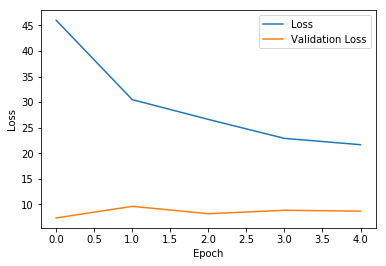

<Figure size 432x288 with 0 Axes>

In [23]:
# Plot the training loss against the validation loss
plt.plot(history.history['regression_loss'])
plt.plot(history.history['val_regression_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])
plt.savefig(fname='./data/lossplot')
plt.show()

plt.clf()